In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import time
import re
from ipaddress import ip_address
from urllib.parse import urlparse
import json
import isodate
from dateutil import parser
from dateutil import tz
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql import Row
from pyspark.sql import functions as pyspark_function
from urllib.request import urlopen
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import mktime
import time

In [2]:
import findspark
findspark.init()
import pyspark
import random
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.functions as pyf
import numpy as np
import pandas 
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


        
spark = SparkSession \
        .builder \
        .appName("Test Spark") \
        .config("spark.jars", "/opt/postgresql-42.4.0.jar") \
        .config("spark.num.executors"," 16")  \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.memory", "20g") \
        .config("spark.scheduler.mode", "FAIR") \
        .config("spark.sql.autoBroadcastJoinThreshold", -1) \
        .master("spark://131.225.58.251:7077") \
        .getOrCreate() \



#spark.conf.set("spark.executor.memory", "20g")
#spark.conf.set("spark.executor.cores", "8")

22/07/15 15:00:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/15 15:00:37 WARN FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.


In [4]:
df = spark.read \
     .format("jdbc") \
     .option("url", "jdbc:postgresql://fndca5b:5432/billing") \
     .option("dbtable", "(select *,  split_part(storageclass, '.', 1) as vo from storageinfo where datestamp between '2022-01-01 00:00:00' and '2022-06-30 23:59:59') as foo") \
     .option("user", "enstore_reader") \
     .option("driver", "org.postgresql.Driver") \
     .option("numPartitions", "16") \
     .option("partitionColumn", "datestamp") \
     .option("lowerBound", "2022-01-01 00:00:00") \
     .option("upperBound", "2022-06-30 23:59:59") \
     .option("fetchsize", 1000000) \
     .load()

df.printSchema()

root
 |-- queuedtime: long (nullable = true)
 |-- fullsize: long (nullable = true)
 |-- storageclass: string (nullable = true)
 |-- connectiontime: long (nullable = true)
 |-- action: string (nullable = true)
 |-- cellname: string (nullable = true)
 |-- datestamp: timestamp (nullable = true)
 |-- errorcode: integer (nullable = true)
 |-- errormessage: string (nullable = true)
 |-- pnfsid: string (nullable = true)
 |-- transaction: string (nullable = true)
 |-- vo: string (nullable = true)



In [5]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,queuedtime,bigint
1,fullsize,bigint
2,storageclass,string
3,connectiontime,bigint
4,action,string
5,cellname,string
6,datestamp,timestamp
7,errorcode,int
8,errormessage,string
9,pnfsid,string


In [6]:
import time
t0 = time.time()
print("Number of entries is    =====> ", df.count(), " Time to execute ", time.time()-t0)

Number of entries is    =====>  68915550  Time to execute  16.22829246520996


In [7]:
df.createOrReplaceTempView("billing")
df.cache()
print("Number of entries again =====> ", df.count(), " Time to execute ", time.time()-t0)

DataFrame[queuedtime: bigint, fullsize: bigint, storageclass: string, connectiontime: bigint, action: string, cellname: string, datestamp: timestamp, errorcode: int, errormessage: string, pnfsid: string, transaction: string, vo: string]

Number of entries again =====>  68915550  Time to execute  410.7457363605499


In [8]:
df_vo = spark.sql("SELECT DISTINCT(vo), COUNT(vo) AS number_of_stores FROM billing WHERE action='store' and errorcode = 0 group by vo order by number_of_stores  desc ")
df_vo.show()

+---------+----------------+
|       vo|number_of_stores|
+---------+----------------+
|   uboone|        14188391|
|     nova|         6188980|
|      GM2|         3513864|
|     dune|         1209244|
|   Simons|         1089287|
|     mu2e|          623474|
|   icarus|          573271|
|     lqcd|          274005|
|     ADMX|          261797|
|  snoplus|           65781|
|  netflow|           60280|
|    annie|           59615|
|     next|           23774|
|     e906|            7699|
|     test|            7577|
|   lariat|            5792|
|  accelai|            5558|
|      des|            2197|
|    minos|             736|
|fermigrid|             716|
+---------+----------------+
only showing top 20 rows



In [9]:
df_vo.count()

27

In [10]:
write_per_store = spark.sql("select DISTINCT(action) from billing where action='store'")
write_per_store.show()

+------+
|action|
+------+
| store|
+------+



In [11]:
unioned_df = write_per_store.join(df_vo)
unioned_df.show(100)

+------+---------+----------------+
|action|       vo|number_of_stores|
+------+---------+----------------+
| store|   uboone|        14188391|
| store|     nova|         6188980|
| store|      GM2|         3513864|
| store|     dune|         1209244|
| store|   Simons|         1089287|
| store|     mu2e|          623474|
| store|   icarus|          573271|
| store|     lqcd|          274005|
| store|     ADMX|          261797|
| store|  snoplus|           65781|
| store|  netflow|           60280|
| store|    annie|           59615|
| store|     next|           23774|
| store|     e906|            7699|
| store|     test|            7577|
| store|   lariat|            5792|
| store|  accelai|            5558|
| store|      des|            2197|
| store|    minos|             736|
| store|fermigrid|             716|
| store|  minerva|             443|
| store|    e1039|             240|
| store|    test2|              11|
| store|  backups|               6|
| store|    damic|          

In [12]:
d1=unioned_df.toPandas()
print(d1)

   action         vo  number_of_stores
0   store       nova           6188980
1   store      annie             59615
2   store       dune           1209244
3   store      e1039               240
4   store     Simons           1089287
5   store      test2                11
6   store     lariat              5792
7   store     uboone          14188391
8   store    accelai              5558
9   store        des              2197
10  store       e906              7699
11  store    snoplus             65781
12  store       lqcd            274005
13  store        GM2           3513864
14  store  fermigrid               716
15  store       mu2e            623474
16  store       test              7577
17  store     icarus            573271
18  store    minerva               443
19  store    backups                 6
20  store       ADMX            261797
21  store       sbnd                 1
22  store      minos               736
23  store    netflow             60280
24  store      damic     

In [13]:
d1=d1.sort_values(by=['number_of_stores'], ascending=False)

In [14]:
print(d1)

   action         vo  number_of_stores
7   store     uboone          14188391
0   store       nova           6188980
13  store        GM2           3513864
2   store       dune           1209244
4   store     Simons           1089287
15  store       mu2e            623474
17  store     icarus            573271
12  store       lqcd            274005
20  store       ADMX            261797
11  store    snoplus             65781
23  store    netflow             60280
1   store      annie             59615
25  store       next             23774
10  store       e906              7699
16  store       test              7577
6   store     lariat              5792
8   store    accelai              5558
9   store        des              2197
22  store      minos               736
14  store  fermigrid               716
18  store    minerva               443
3   store      e1039               240
5   store      test2                11
19  store    backups                 6
24  store      damic     

<AxesSubplot:xlabel='vo'>

Text(0.5, 0, 'vo')

Text(0, 0.5, 'number_of_stores')

/tmp/ipykernel_26758/2045646321.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('stores.png' ,fontsize=24)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'uboone'),
  Text(1, 0, 'nova'),
  Text(2, 0, 'GM2'),
  Text(3, 0, 'dune'),
  Text(4, 0, 'mu2e'),
  Text(5, 0, 'icarus'),
  Text(6, 0, 'next'),
  Text(7, 0, 'annie'),
  Text(8, 0, 'snoplus'),
  Text(9, 0, 'lqcd'),
  Text(10, 0, 'test'),
  Text(11, 0, 'accelai'),
  Text(12, 0, 'des'),
  Text(13, 0, 'fermigrid'),
  Text(14, 0, 'e1039'),
  Text(15, 0, 'Simons'),
  Text(16, 0, 'darkside'),
  Text(17, 0, 'test2'),
  Text(18, 0, 'lariat'),
  Text(19, 0, 'backups')])

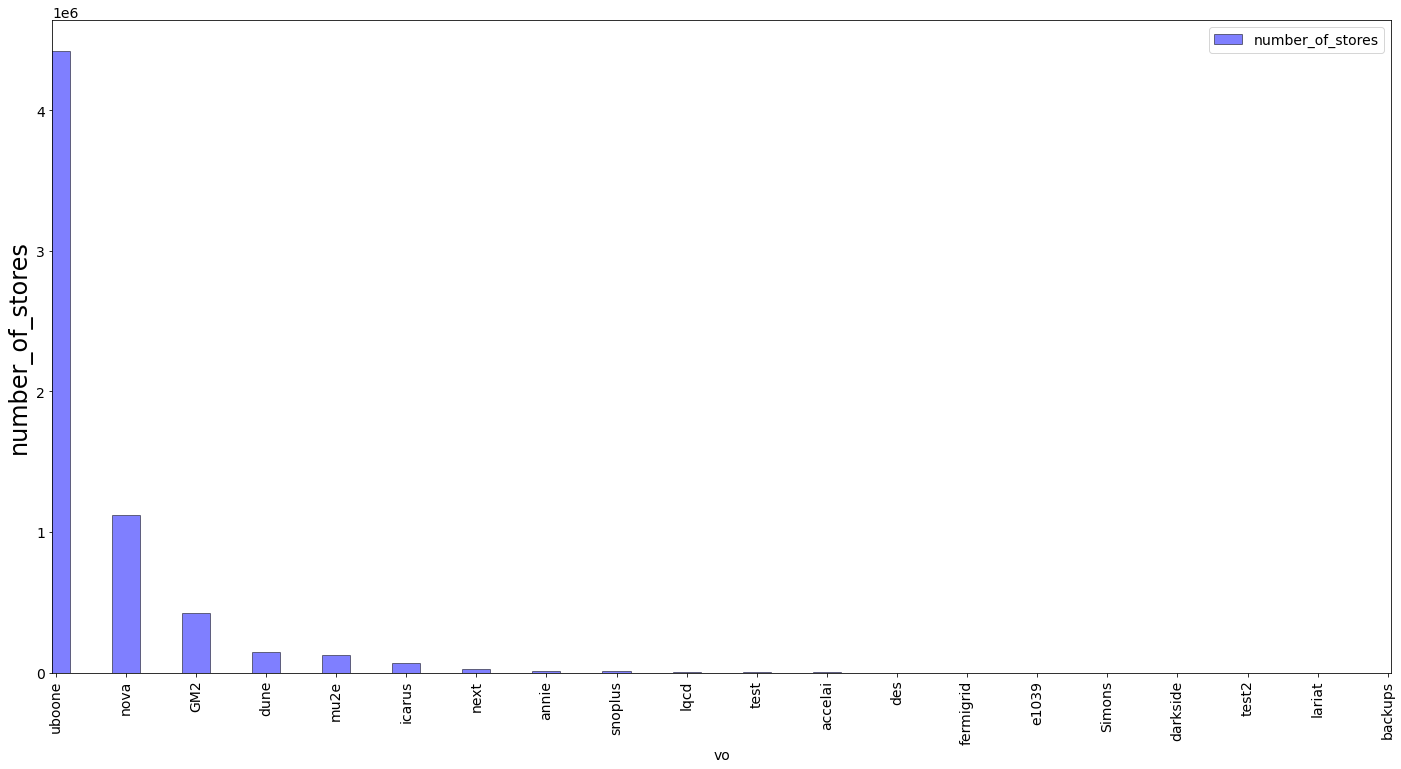

In [44]:
d1.plot.bar(x='vo', y='number_of_stores' , color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12),align='center', width=-0.4)
plt.xlabel("vo")
plt.ylabel("number_of_stores" ,fontsize=24)
plt.savefig('stores.png' ,fontsize=24)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='vo'>

Text(0.5, 0, 'vo')

Text(0, 0.5, 'number_of_stores')

/tmp/ipykernel_19643/381498126.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('number_of_stores_6_months.png' ,fontsize=24)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'uboone'),
  Text(1, 0, 'nova'),
  Text(2, 0, 'GM2'),
  Text(3, 0, 'dune'),
  Text(4, 0, 'Simons'),
  Text(5, 0, 'mu2e'),
  Text(6, 0, 'icarus'),
  Text(7, 0, 'lqcd'),
  Text(8, 0, 'ADMX'),
  Text(9, 0, 'snoplus'),
  Text(10, 0, 'netflow'),
  Text(11, 0, 'annie'),
  Text(12, 0, 'next'),
  Text(13, 0, 'e906'),
  Text(14, 0, 'test'),
  Text(15, 0, 'lariat'),
  Text(16, 0, 'accelai'),
  Text(17, 0, 'des'),
  Text(18, 0, 'minos'),
  Text(19, 0, 'fermigrid'),
  Text(20, 0, 'minerva'),
  Text(21, 0, 'e1039'),
  Text(22, 0, 'test2'),
  Text(23, 0, 'backups'),
  Text(24, 0, 'damic'),
  Text(25, 0, 'darkside'),
  Text(26, 0, 'sbnd')])

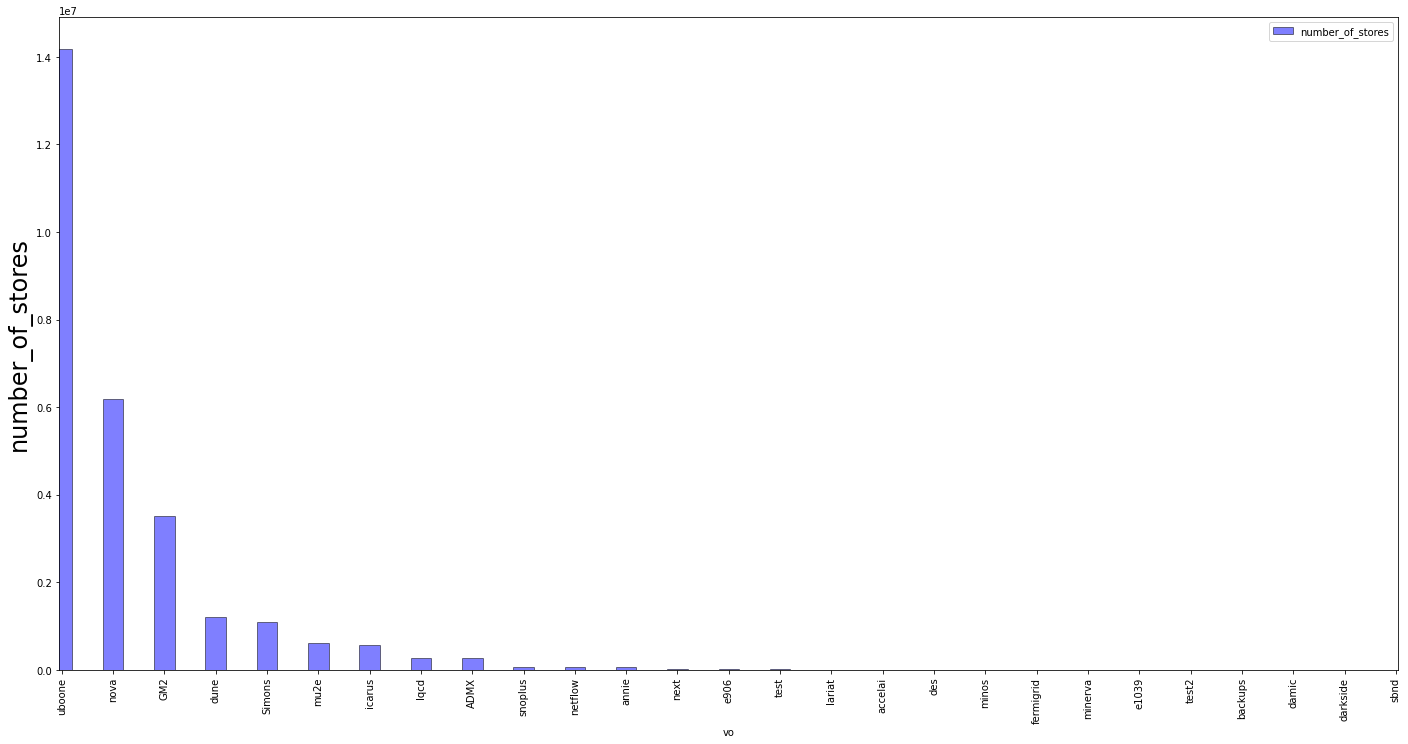

In [15]:
d1.plot.bar(x='vo', y='number_of_stores' , color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12),align='center', width=-0.4)
plt.xlabel("vo")
plt.ylabel("number_of_stores" ,fontsize=24)
plt.savefig('number_of_stores_6_months.png' ,fontsize=24)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=90)
plt.show()